# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import gc
import pickle as pkl

# Data manipulation
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import erf, erfinv
from scipy.integrate import quad
from scipy.signal import savgol_filter, correlate, fftconvolve
from scipy.sparse import csr_matrix, dia_matrix, csc_matrix, coo_matrix
from scipy import fftpack
import torch
from functools import reduce
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'torch device: {device}')

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
import matplotlib.pylab as plb

# From alens_analysis.py
import alens_analysis as aa
from alens_analysis.colormaps import register_cmaps
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
import alens_analysis.chromatin.chrom_poly_stats as cps
import alens_analysis.helpers as ahlp
import alens_analysis.read_func as arf
from alens_analysis import cluster_analysis as cla

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'
cond_path = Path.home() / 'ceph/DATA/Chromatin/CondCharPaper'

torch device: cuda


### Style settings

In [2]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)
        

# Functions

In [13]:
def calc_cond_normal_modes(prot_dat, bead_num, run_params, prot_params):
    k_p = prot_params['proteins'][0]['kappa']
    k_f = run_params['linkKappa']

    # Make crosslinker spring matrix
    connect_mat = cps.get_connect_smat(prot_dat, bead_num)
    prot_spring_mat = (connect_mat + connect_mat.T)*k_p

    # Make diagonal sparse matrix
    rouse_spring_mat = csr_matrix(np.diag(np.ones(bead_num-1), -1) + np.diag(np.ones(bead_num-1), 1))*k_f

    # Make Kirchoff matrix
    spring_mat = prot_spring_mat + rouse_spring_mat
    diag = np.diag(np.array(spring_mat.sum(axis=1))[:,0])
    kirchoff_mat = -spring_mat + diag

    eig_vals, eig_vecs = np.linalg.eig(kirchoff_mat)
    eig_vals = np.sort(eig_vals)

    return eig_vals

In [15]:
def calc_rouse_modes(bead_num, run_params):
    k_f = run_params['linkKappa']

    # Make diagonal sparse matrix
    rouse_spring_mat = csr_matrix(np.diag(np.ones(bead_num-1), -1) + np.diag(np.ones(bead_num-1), 1))*k_f

    # Make Kirchoff matrix
    diag = np.diag(np.array(rouse_spring_mat.sum(axis=1))[:,0])
    kirchoff_rouse_mat = -rouse_spring_mat + diag
    eig_vals, eig_vecs = np.linalg.eig(kirchoff_rouse_mat)
    eig_vals = np.sort(eig_vals)

    return eig_vals

# Data

In [3]:
data_dir_list = {
    # cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1",
    # cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01",
    # cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001",
    # cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001",
    # cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.1",
    # cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.01",
    # cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.001",
    # cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.0001",
}


In [4]:
param_dir = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod30"
# data_dir.exists()

# Analysis of normal modes of the chromatin fiber

## $k_o = 30$ analysis

True

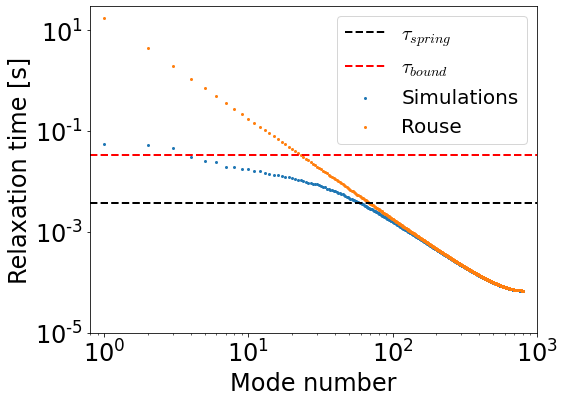

In [17]:
param_dir = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod30"
data_path = next((param_dir / "s1/analysis").glob("raw*.h5"))
data_path.exists()

with h5py.File(data_path, 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
    pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
    prot_dat = h5_data['raw_data/proteins'][:, :, 500]
    syl_dat = h5_data['raw_data/sylinders'][:, :, 500]
    unbinding_rate = pparams['proteins'][0]['ko_d'][1]
    bead_num = syl_dat.shape[0]

    relax_times = 1./calc_cond_normal_modes(prot_dat, bead_num, rparams, pparams)[1:]
    rouse_times = 1./calc_rouse_modes(bead_num, rparams)[1:]

    fig, axarr = plt.subplots(1,1, figsize=(8, 6))
    # axarr.scatter(np.arange(eig_vals.size), 1./reig_vals - 1./eig_vals)
    _ = axarr.scatter(np.arange(1,bead_num), relax_times, label='Simulations')
    _ = axarr.scatter(np.arange(1,bead_num), rouse_times, label='Rouse')
    _ = axarr.axhline(0.003769911184307752, color='k', linestyle='--', label=r'$\tau_{{spring}}$')
    _ = axarr.axhline(1./unbinding_rate, color='r', linestyle='--', label=r'$\tau_{{bound}}$')
    _ = axarr.set_yscale('log')
    _ = axarr.set_xscale('log')
    _ = axarr.set_xlim(.8, 1000)
    _ = axarr.set_ylim(1e-5, 30)
    _ = axarr.set_xlabel('Mode number')
    _ = axarr.set_ylabel('Relaxation time [s]')
    _ = axarr.legend()
    




## Multiple time point analysis of single param value

True

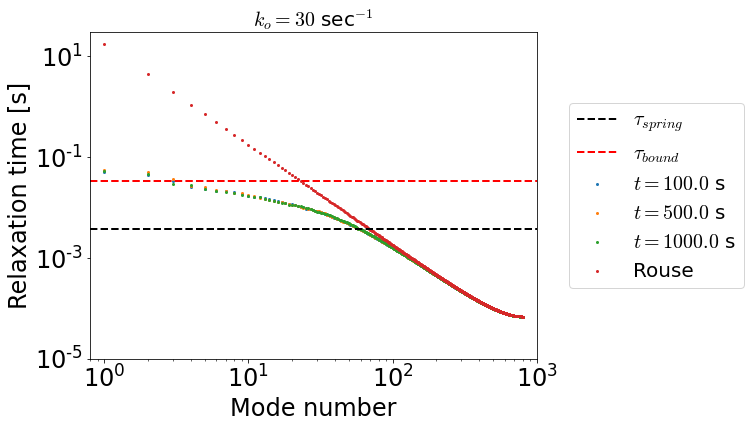

In [25]:
param_dir = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod30"
data_path = next((param_dir / "s1/analysis").glob("raw*.h5"))
data_path.exists()

with h5py.File(data_path, 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
    pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
    prot_dat = h5_data['raw_data/proteins'][:, :, :]
    syl_dat = h5_data['raw_data/sylinders'][:, :, :]
    unbinding_rate = pparams['proteins'][0]['ko_d'][1]
    bead_num = syl_dat.shape[0]
    fig, axarr = plt.subplots(1,1, figsize=(8, 6))
    for i in [1001, 5001, 10001]:
        relax_times = 1./calc_cond_normal_modes(prot_dat[:,:,i], bead_num, rparams, pparams)[1:]
        _ = axarr.scatter(np.arange(1,bead_num), relax_times, label=f'$t = {time_arr[i]}$ s')

    rouse_times = 1./calc_rouse_modes(bead_num, rparams)[1:]
    _ = axarr.scatter(np.arange(1,bead_num), rouse_times, label='Rouse')


    _ = axarr.axhline(0.003769911184307752, color='k', linestyle='--', label=r'$\tau_{{spring}}$')
    _ = axarr.axhline(1./unbinding_rate, color='r', linestyle='--', label=r'$\tau_{{bound}}$')
    _ = axarr.set_yscale('log')
    _ = axarr.set_xscale('log')
    _ = axarr.set_xlim(.8, 1000)
    _ = axarr.set_ylim(1e-5, 30)
    _ = axarr.set_title('$k_{{o}} = 30$ sec$^{{-1}}$')
    _ = axarr.set_xlabel('Mode number')
    _ = axarr.set_ylabel('Relaxation time [s]')
    _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    
    
    




True

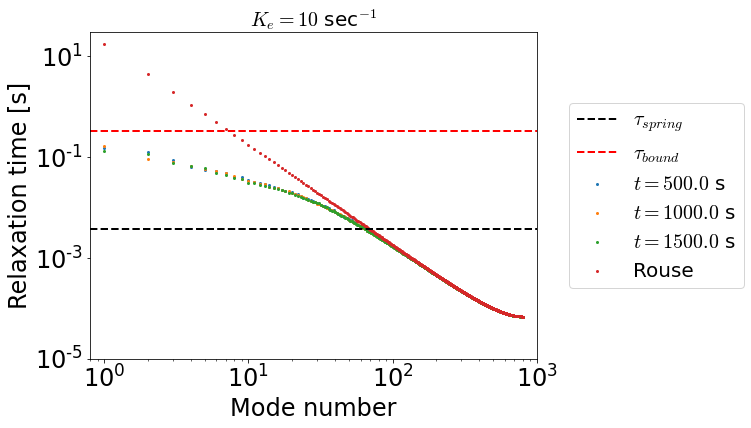

In [47]:
param_dir = cond_path / '23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke10'
data_path = next((param_dir / "s1/analysis").glob("raw*.h5"))
data_path.exists()

with h5py.File(data_path, 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
    pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
    prot_dat = h5_data['raw_data/proteins'][:, :, :]
    syl_dat = h5_data['raw_data/sylinders'][:, :, :]
    unbinding_rate = pparams['proteins'][0]['ko_d'][1]
    bead_num = syl_dat.shape[0]
    fig, axarr = plt.subplots(1,1, figsize=(8, 6))
    for i in [1001, 2001, 3001]:
        relax_times = 1./calc_cond_normal_modes(prot_dat[:,:,i], bead_num, rparams, pparams)[1:]
        _ = axarr.scatter(np.arange(1,bead_num), relax_times, label=f'$t = {time_arr[i]}$ s')

    rouse_times = 1./calc_rouse_modes(bead_num, rparams)[1:]
    _ = axarr.scatter(np.arange(1,bead_num), rouse_times, label='Rouse')


    _ = axarr.axhline(0.003769911184307752, color='k', linestyle='--', label=r'$\tau_{{spring}}$')
    _ = axarr.axhline(1./unbinding_rate, color='r', linestyle='--', label=r'$\tau_{{bound}}$')
    _ = axarr.set_yscale('log')
    _ = axarr.set_xscale('log')
    _ = axarr.set_xlim(.8, 1000)
    _ = axarr.set_ylim(1e-5, 30)
    _ = axarr.set_title('$K_{{e}} = 10$ sec$^{{-1}}$')
    _ = axarr.set_xlabel('Mode number')
    _ = axarr.set_ylabel('Relaxation time [s]')
    _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    
    
    




True

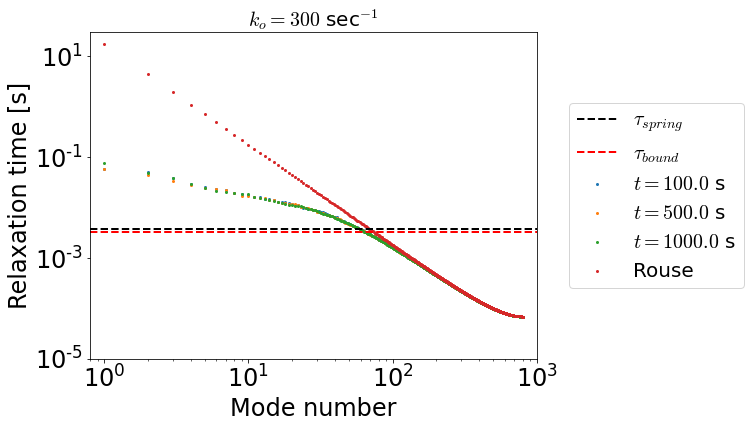

In [27]:
param_dir = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod300"
data_path = next((param_dir / "s1/analysis").glob("raw*.h5"))
data_path.exists()

with h5py.File(data_path, 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
    pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
    prot_dat = h5_data['raw_data/proteins'][:, :, :]
    syl_dat = h5_data['raw_data/sylinders'][:, :, :]
    unbinding_rate = pparams['proteins'][0]['ko_d'][1]
    bead_num = syl_dat.shape[0]
    fig, axarr = plt.subplots(1,1, figsize=(8, 6))
    for i in [1001, 5001, 10001]:
        relax_times = 1./calc_cond_normal_modes(prot_dat[:,:,i], bead_num, rparams, pparams)[1:]
        _ = axarr.scatter(np.arange(1,bead_num), relax_times, label=f'$t = {time_arr[i]}$ s')

    rouse_times = 1./calc_rouse_modes(bead_num, rparams)[1:]
    _ = axarr.scatter(np.arange(1,bead_num), rouse_times, label='Rouse')


    _ = axarr.axhline(0.003769911184307752, color='k', linestyle='--', label=r'$\tau_{{spring}}$')
    _ = axarr.axhline(1./unbinding_rate, color='r', linestyle='--', label=r'$\tau_{{bound}}$')
    _ = axarr.set_yscale('log')
    _ = axarr.set_xscale('log')
    _ = axarr.set_xlim(.8, 1000)
    _ = axarr.set_ylim(1e-5, 30)
    _ = axarr.set_title('$k_{{o}} = 300$ sec$^{{-1}}$')
    _ = axarr.set_xlabel('Mode number')
    _ = axarr.set_ylabel('Relaxation time [s]')
    _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    
    
    




True

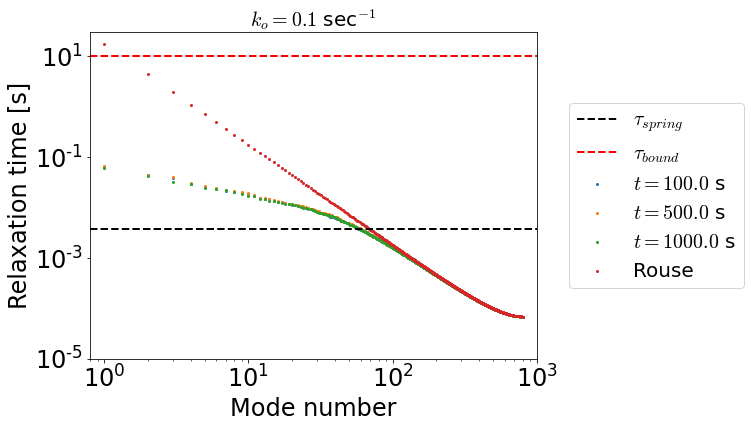

In [29]:
param_dir = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod0.1"
data_path = next((param_dir / "s1/analysis").glob("raw*.h5"))
data_path.exists()

with h5py.File(data_path, 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
    pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
    prot_dat = h5_data['raw_data/proteins'][:, :, :]
    syl_dat = h5_data['raw_data/sylinders'][:, :, :]
    unbinding_rate = pparams['proteins'][0]['ko_d'][1]
    bead_num = syl_dat.shape[0]
    fig, axarr = plt.subplots(1,1, figsize=(8, 6))
    for i in [1001, 5001, 10001]:
        relax_times = 1./calc_cond_normal_modes(prot_dat[:,:,i], bead_num, rparams, pparams)[1:]
        _ = axarr.scatter(np.arange(1,bead_num), relax_times, label=f'$t = {time_arr[i]}$ s')

    rouse_times = 1./calc_rouse_modes(bead_num, rparams)[1:]
    _ = axarr.scatter(np.arange(1,bead_num), rouse_times, label='Rouse')


    _ = axarr.axhline(0.003769911184307752, color='k', linestyle='--', label=r'$\tau_{{spring}}$')
    _ = axarr.axhline(1./unbinding_rate, color='r', linestyle='--', label=r'$\tau_{{bound}}$')
    _ = axarr.set_yscale('log')
    _ = axarr.set_xscale('log')
    _ = axarr.set_xlim(.8, 1000)
    _ = axarr.set_ylim(1e-5, 30)
    _ = axarr.set_title('$k_{{o}} = 0.1$ sec$^{{-1}}$')
    _ = axarr.set_xlabel('Mode number')
    _ = axarr.set_ylabel('Relaxation time [s]')
    _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    
    
    




## Multiple seed analysis of single param value

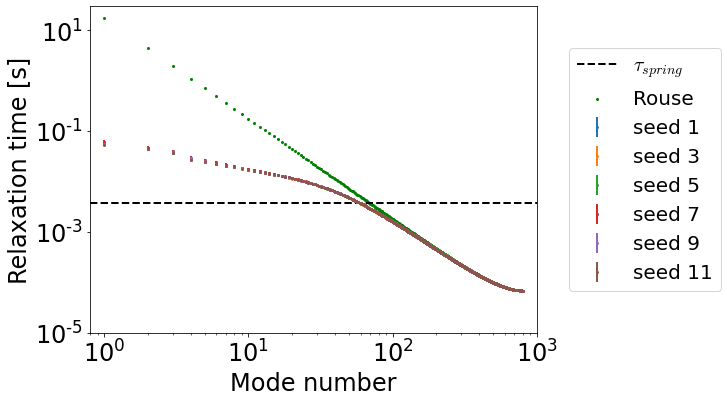

In [66]:
param_dir = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod30"

fig, axarr = plt.subplots(1,1, figsize=(8, 6))
for s in range(1, 13, 2) :
    sd_str  = f"s{s}/analysis"
    data_path = next((param_dir / sd_str).glob("raw*.h5"))
    with h5py.File(data_path, 'r+') as h5_data:
        time_arr = h5_data['time'][...]
        rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
        pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
        prot_dat = h5_data['raw_data/proteins'][:, :, :]
        syl_dat = h5_data['raw_data/sylinders'][:, :, :]
        unbinding_rate = pparams['proteins'][0]['ko_d'][1]
        bead_num = syl_dat.shape[0]
        n_times =  10
        relax_times = np.zeros((n_times, bead_num-1))
        n=0
        for i in np.linspace(1, prot_dat.shape[2]-1, n_times, dtype=int):
            relax_times[n] += 1./calc_cond_normal_modes(prot_dat[:,:,i], bead_num, rparams, pparams)[1:]
            n+=1
        _ = axarr.errorbar(np.arange(1,bead_num), relax_times.mean(axis=0), yerr=relax_times.std(axis=0), label=f'seed {s}', marker='o', linestyle='none')

rouse_times = 1./calc_rouse_modes(bead_num, rparams)[1:]
_ = axarr.scatter(np.arange(1,bead_num), rouse_times, label='Rouse', c='g')


_ = axarr.axhline(0.003769911184307752, color='k', linestyle='--', label=r'$\tau_{{spring}}$')
# _ = axarr.axhline(1./unbinding_rate, color='r', linestyle='--', label=r'$\tau_{{bound}}$')
_ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
_ = axarr.set_xlim(.8, 1000)
_ = axarr.set_ylim(1e-5, 30)
# _ = axarr.set_title('$k_{{o}} = 30$ sec$^{{-1}}$')
_ = axarr.set_xlabel('Mode number')
_ = axarr.set_ylabel('Relaxation time [s]')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))

## Different $k_o$ values

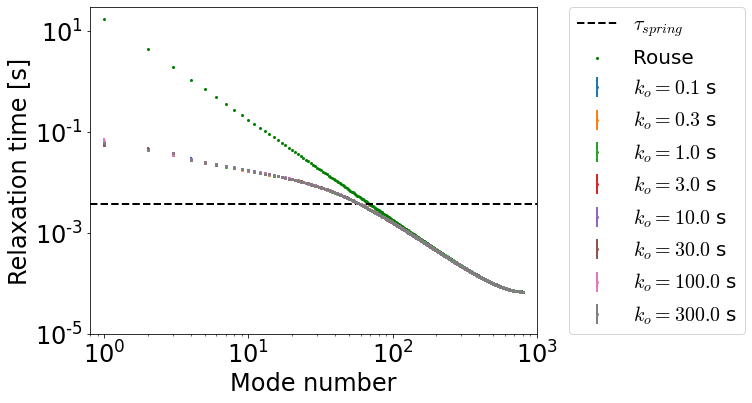

In [65]:
param_dirs = [
    cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod0.1",
    cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod0.3",
    cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod1",
    cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod3",
    cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod10",
    cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod30",
    cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod100",
    cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod300",
    ]

fig, axarr = plt.subplots(1,1, figsize=(8, 6))
for pdir in param_dirs:
    data_path = next((pdir / "s1/analysis").glob("raw*.h5"))
    with h5py.File(data_path, 'r+') as h5_data:
        time_arr = h5_data['time'][...]
        rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
        pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
        prot_dat = h5_data['raw_data/proteins'][:, :, :]
        syl_dat = h5_data['raw_data/sylinders'][:, :, :]
        unbinding_rate = pparams['proteins'][0]['ko_d'][1]
        bead_num = syl_dat.shape[0]
        n_times =  10
        relax_times = np.zeros((n_times, bead_num-1))
        n=0
        for i in np.linspace(1, prot_dat.shape[2]-1, n_times, dtype=int):
            relax_times[n] += 1./calc_cond_normal_modes(prot_dat[:,:,i], bead_num, rparams, pparams)[1:]
            n+=1
        _ = axarr.errorbar(np.arange(1,bead_num), relax_times.mean(axis=0), yerr=relax_times.std(axis=0), label=f'$k_o = {unbinding_rate}$ s', marker='o', linestyle='none')

rouse_times = 1./calc_rouse_modes(bead_num, rparams)[1:]
_ = axarr.scatter(np.arange(1,bead_num), rouse_times, label='Rouse', c='g')


_ = axarr.axhline(0.003769911184307752, color='k', linestyle='--', label=r'$\tau_{{spring}}$')
# _ = axarr.axhline(1./unbinding_rate, color='r', linestyle='--', label=r'$\tau_{{bound}}$')
_ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
_ = axarr.set_xlim(.8, 1000)
_ = axarr.set_ylim(1e-5, 30)
# _ = axarr.set_title('$k_{{o}} = 30$ sec$^{{-1}}$')
_ = axarr.set_xlabel('Mode number')
_ = axarr.set_ylabel('Relaxation time [s]')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))

## Different $K_e$ values

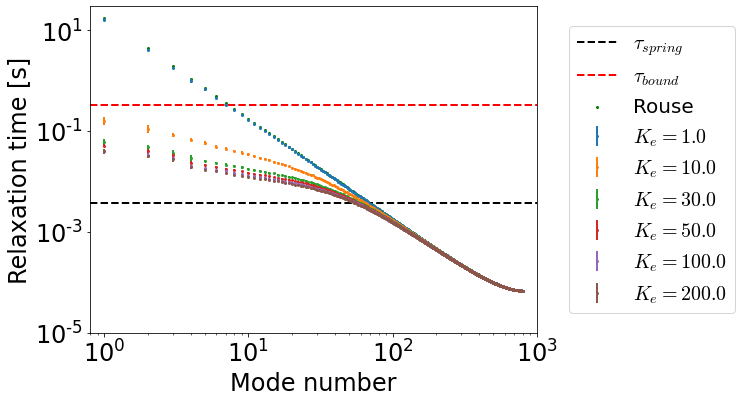

In [54]:
param_dirs = [
    cond_path / '23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke1',
    cond_path / '23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke10',
    cond_path / '23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke30',
    cond_path / '23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke50',
    cond_path / '23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke100',
    cond_path / '23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke200',
    ]

fig, axarr = plt.subplots(1,1, figsize=(8, 6))
for pdir in param_dirs:
    data_path = next((pdir / "s1/analysis").glob("raw*.h5"))
    with h5py.File(data_path, 'r+') as h5_data:
        time_arr = h5_data['time'][...]
        rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
        pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
        prot_dat = h5_data['raw_data/proteins'][:, :, :]
        syl_dat = h5_data['raw_data/sylinders'][:, :, :]
        unbinding_rate = pparams['proteins'][0]['ko_d'][1]
        Ke = pparams['proteins'][0]['Ke'][1]
        bead_num = syl_dat.shape[0]
        n_times =  10
        relax_times = np.zeros((n_times, bead_num-1))
        n=0
        for i in np.linspace(2000, prot_dat.shape[2]-1, n_times, dtype=int):
            relax_times[n] += 1./calc_cond_normal_modes(prot_dat[:,:,i], bead_num, rparams, pparams)[1:]
            n+=1
        _ = axarr.errorbar(np.arange(1,bead_num), relax_times.mean(axis=0), yerr=relax_times.std(axis=0), label=f'$K_e = {Ke}$', marker='o', linestyle='none')
        # _ = axarr.scatter(np.arange(1,bead_num), relax_times.mean(axis=0), label=f'$Ke = {Ke}$ s', marker='o')

rouse_times = 1./calc_rouse_modes(bead_num, rparams)[1:]
_ = axarr.scatter(np.arange(1,bead_num), rouse_times, label='Rouse', c='g')


_ = axarr.axhline(0.003769911184307752, color='k', linestyle='--', label=r'$\tau_{{spring}}$')
# _ = axarr.axhline(0.003769911184307752, color='k', linestyle='--', label=r'$\tau_{{rot}}$')
_ = axarr.axhline(1./unbinding_rate, color='r', linestyle='--', label=r'$\tau_{{bound}}$')
_ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
_ = axarr.set_xlim(.8, 1000)
_ = axarr.set_ylim(1e-5, 30)
# _ = axarr.set_title('$k_{{o}} = 30$ sec$^{{-1}}$')
_ = axarr.set_xlabel('Mode number')
_ = axarr.set_ylabel('Relaxation time [s]')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))

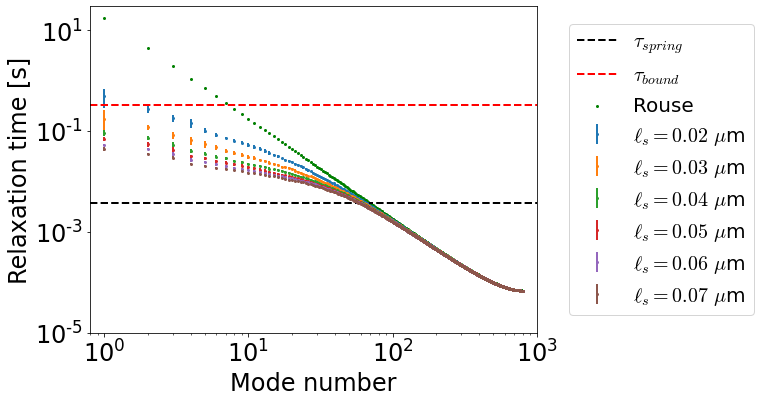

In [55]:
param_dirs = [
    cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.02',
    cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.03',
    cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.04',
    cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.05',
    cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.06',
    cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.07',
    ]

fig, axarr = plt.subplots(1,1, figsize=(8, 6))
for pdir in param_dirs:
    data_path = next((pdir / "s1/analysis").glob("raw*.h5"))
    with h5py.File(data_path, 'r+') as h5_data:
        time_arr = h5_data['time'][...]
        rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
        pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
        prot_dat = h5_data['raw_data/proteins'][:, :, :]
        syl_dat = h5_data['raw_data/sylinders'][:, :, :]
        # unbinding_rate = pparams['proteins'][0]['ko_d'][1]
        ls = pparams['proteins'][0]['freeLength']
        bead_num = syl_dat.shape[0]
        n_times =  10
        relax_times = np.zeros((n_times, bead_num-1))
        n=0
        for i in np.linspace(2000, prot_dat.shape[2]-1, n_times, dtype=int):
            relax_times[n] += 1./calc_cond_normal_modes(prot_dat[:,:,i], bead_num, rparams, pparams)[1:]
            n+=1
        _ = axarr.errorbar(np.arange(1,bead_num), relax_times.mean(axis=0), yerr=relax_times.std(axis=0), label=f'$\ell_s = {ls}$ $\mu$m', marker='o', linestyle='none')
        # _ = axarr.scatter(np.arange(1,bead_num), relax_times.mean(axis=0), label=f'$Ke = {Ke}$ s', marker='o')

rouse_times = 1./calc_rouse_modes(bead_num, rparams)[1:]
_ = axarr.scatter(np.arange(1,bead_num), rouse_times, label='Rouse', c='g')


_ = axarr.axhline(0.003769911184307752, color='k', linestyle='--', label=r'$\tau_{{spring}}$')
# _ = axarr.axhline(0.003769911184307752, color='k', linestyle='--', label=r'$\tau_{{rot}}$')
_ = axarr.axhline(1./unbinding_rate, color='r', linestyle='--', label=r'$\tau_{{bound}}$')
_ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
_ = axarr.set_xlim(.8, 1000)
_ = axarr.set_ylim(1e-5, 30)
# _ = axarr.set_title('$k_{{o}} = 30$ sec$^{{-1}}$')
_ = axarr.set_xlabel('Mode number')
_ = axarr.set_ylabel('Relaxation time [s]')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))

## Covariance matrix

True

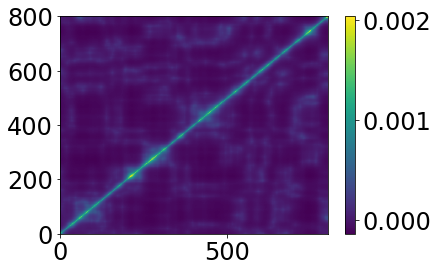

In [104]:
data_path = next((param_dir / "s1/analysis").glob("raw*.h5"))
data_path.exists()

with h5py.File(data_path, 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
    pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
    prot_dat = h5_data['raw_data/proteins'][:, :, 500]
    # print(rparams)

    k_p = pparams['proteins'][0]['kappa']
    k_f = rparams['linkKappa']

    connect_mat = cps.get_connect_smat(prot_dat)
    prot_spring_mat = (connect_mat + connect_mat.T)*k_p
    # Make diagonal sparse matrix

    rouse_spring_mat = csr_matrix(np.diag(np.ones(prot_dat.shape[0]-1), -1) + np.diag(np.ones(prot_dat.shape[0]-1), 1))*k_f

    spring_mat = prot_spring_mat + rouse_spring_mat
    # print(spring_mat.todense())
    diag = np.diag(np.array(spring_mat.sum(axis=1))[:,0])
    kirchoff_mat = -spring_mat + diag

    diag = np.diag(np.array(rouse_spring_mat.sum(axis=1))[:,0])
    kirchoff_rouse_mat = -rouse_spring_mat + diag

    eig_vals, eig_vecs = np.linalg.eig(kirchoff_mat)
    zero_ind = np.where(eig_vals == 0)

    mod_eig = np.delete(eig_vals, zero_ind)
    mod_eig_vecs = np.delete(eig_vecs, zero_ind, 1)

    inv_eig_vals = np.power(mod_eig, -1)
    # sort_ind = np.sort(inv_eig_vals)
    # print(sort_ind)

    cov_mat = np.einsum('i,ji,ki->jk', inv_eig_vals, mod_eig_vecs, mod_eig_vecs)
    c = plt.pcolor(cov_mat)
    plt.colorbar(c)

    
    
    # reig_vals, reig_vecs = np.linalg.eig(kirchoff_rouse_mat)

    # fig, axarr = plt.subplots(1,1, figsize=(8, 6))
    # axarr.scatter(np.arange(eig_vals.size),reig_vals - eig_vals)
    # axarr.set_yscale('log')
    # axarr.set_ylim(1e-1, 2e2)
    # axarr.set_xscale('log')
    
    # plt.plot(eig_vals)



# print(connect_mat.todense())

True

(array([755]),)


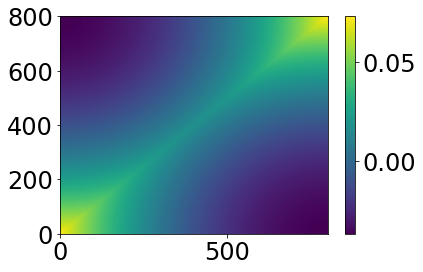

In [101]:
data_path = next((param_dir / "s1/analysis").glob("raw*.h5"))
data_path.exists()

with h5py.File(data_path, 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
    pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
    prot_dat = h5_data['raw_data/proteins'][:, :, 500]
    # print(rparams)

    k_p = pparams['proteins'][0]['kappa']
    k_f = rparams['linkKappa']

    connect_mat = cps.get_connect_smat(prot_dat)
    prot_spring_mat = (connect_mat + connect_mat.T)*k_p

    rouse_spring_mat = csr_matrix(np.diag(np.ones(prot_dat.shape[0]-1), -1) + np.diag(np.ones(prot_dat.shape[0]-1), 1))*k_f

    spring_mat = prot_spring_mat + rouse_spring_mat
    diag = np.diag(np.array(spring_mat.sum(axis=1))[:,0])
    kirchoff_mat = -spring_mat + diag

    diag = np.diag(np.array(rouse_spring_mat.sum(axis=1))[:,0])
    kirchoff_rouse_mat = -rouse_spring_mat + diag

    eig_vals, eig_vecs = np.linalg.eig(kirchoff_rouse_mat)
    zero_ind = np.where(eig_vals < 1e-10)
    print(zero_ind)
    

    mod_eig = np.delete(eig_vals, zero_ind)
    mod_eig_vecs = np.delete(eig_vecs, zero_ind, 1)

    inv_eig_vals = np.power(mod_eig, -1)

    cov_mat = np.einsum('i,ji,ki->jk', inv_eig_vals, mod_eig_vecs, mod_eig_vecs)
    c = plt.pcolor(cov_mat)
    plt.colorbar(c)



# print(connect_mat.todense())